# Newly Predicted Cancer Genes
This notebook will generate a consensus list of new predictions (genes that were not previously listed as cancer genes but that we  are predicting as new candidates). It will further prove that the predictions are meaningful by:

1. Showing that our new predictions interact with lots of known cancer genes
2. Showing that our new predictions tend to be essential in tumor cell lines

In [1]:
# data science classics
import pandas as pd
import numpy as np
import os, sys, operator
import scipy

# utility functions
sys.path.append(os.path.abspath('../EMOGI'))
import postprocessing
import gcnIO

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#plt.rc('text', usetex=True)

%matplotlib inline

## Relevant Paths

* `all_models_dir`: The directory in which models for all relevant PPI networks reside. The directory should have the network names as folders and each of the folders then must contain the results from multi-omics-trainings.
* `reference_model_dir`: The directory where the most relevant model resides. Can be one of the directories inside the `all_models_dir` but not a multi-omics training.
* `achilles_data_path`: Path to the achilles CRSIPR gene effect csv file that can be downloaded [here](https://depmap.org/portal/download/)

In [2]:
#all_models_dir = '../data/GCN/training/final_TCGA_all_networks/'
#reference_model_dir = '../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/'
all_models_dir = '../data/GCN/training/Rev1_CNA_separated_all_networks/'
reference_model_dir = '../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB/'
achilles_data_path = '../data/pancancer/Achilles/Achilles_gene_effect.csv'

## Parameters

* `top_n`: The number of top predictions per model to consider for computation of newly predicted cancer genes (consensus calculation)
* `all_omics`: Whether to use all omics (Mutation, DNA Methylation, Expression and combinations of two types of data) or only the multi-omics models for calculation of newly predicted cancer genes

In [3]:
top_n = 100
all_omics = False

## 1. Compute Consenus Predictions from different Multi-Omics Training

In [4]:
consensus_predicted = {}
checked_models = 0
for network in os.listdir(all_models_dir):
    network_path = os.path.join(all_models_dir, network)
    if os.path.isdir(network_path) and not network == 'CPDB_notsogood' and os.path.isfile(os.path.join(network_path, 'hyper_params.txt')):
        print (network)
        model_path = network_path
        predictions_topn = postprocessing.load_predictions(model_path).head(top_n)
        non_cancer_hits = predictions_topn[~predictions_topn.label]
        for gene in non_cancer_hits.Name:
            if not gene in consensus_predicted:
                consensus_predicted[gene] = 1
            else:
                consensus_predicted[gene] += 1
        checked_models += 1

#consensus_predicted = {k: consensus_predicted[k] for k in consensus_predicted if consensus_predicted[k] > 1}
print ("{} different non-cancer genes in top {} predictions across all 6 PPI networks!".format(len(consensus_predicted), top_n))
consensus_sorted = sorted(consensus_predicted.items(), key=operator.itemgetter(1), reverse=True)

CPDB
PCNet
STRINGdb
IRefIndex
Multinet
IRefIndex_2015
165 different non-cancer genes in top 100 predictions across all 6 PPI networks!


In [5]:
"""
consensus_predicted = {}
checked_models = 0
for network in os.listdir(all_models_dir):
    print (network)
    network_path = os.path.join(all_models_dir, network)
    if all_omics:
        if os.path.isdir(network_path) and not network.startswith('.'):
            for omics in os.listdir(network_path):
                model_path = os.path.join(network_path, omics)
                if os.path.isdir(model_path) and not omics.startswith('.'):
                    predictions_topn = postprocessing.load_predictions(model_path).head(top_n)
                    non_cancer_hits = predictions_topn[~predictions_topn.label]
                    for gene in non_cancer_hits.Name:
                        if not gene in consensus_predicted:
                            consensus_predicted[gene] = 1
                        else:
                            consensus_predicted[gene] += 1
                    checked_models += 1
    else:
        if os.path.isdir(network_path) and os.path.isdir(os.path.join(network_path, 'multiomics')):
            model_path = os.path.join(network_path, 'multiomics')
            predictions_topn = postprocessing.load_predictions(model_path).head(top_n)
            non_cancer_hits = predictions_topn[~predictions_topn.label]
            for gene in non_cancer_hits.Name:
                if not gene in consensus_predicted:
                    consensus_predicted[gene] = 1
                else:
                    consensus_predicted[gene] += 1
            checked_models += 1

#consensus_predicted = {k: consensus_predicted[k] for k in consensus_predicted if consensus_predicted[k] > 1}
print ("{} different non-cancer genes in top {} predictions across all 7 omics data types!".format(len(consensus_predicted), top_n))
consensus_sorted = sorted(consensus_predicted.items(), key=operator.itemgetter(1), reverse=True)
"""
print()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


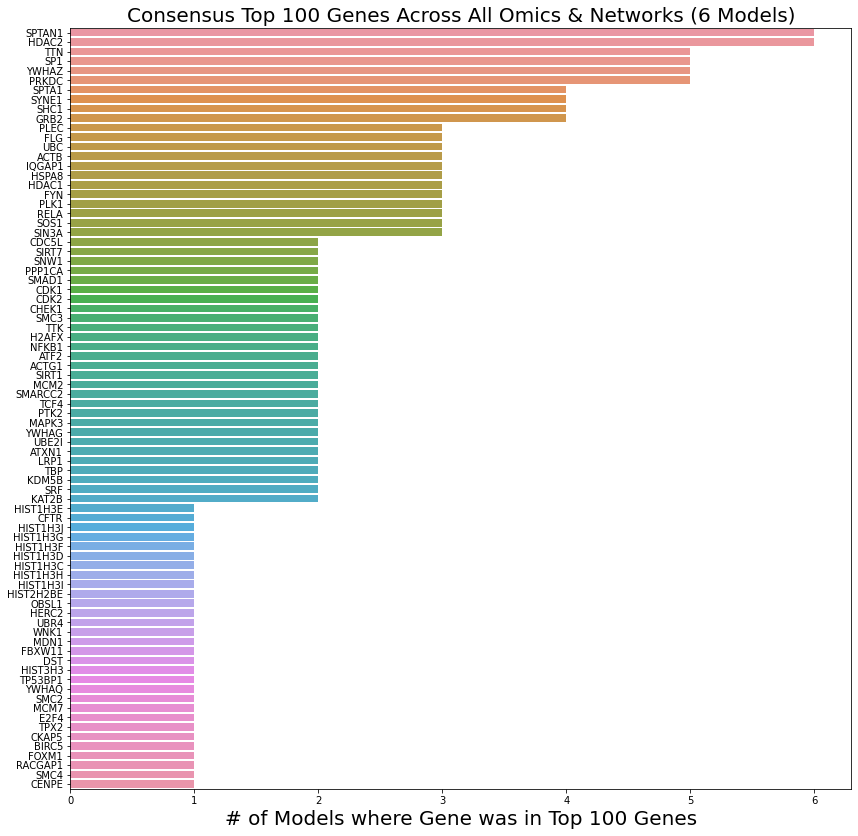

In [6]:
to_plot = consensus_sorted[:80]
fig = plt.figure(figsize=(14, 14))
sns.barplot(y=[i[0] for i in to_plot], x=[i[1] for i in to_plot], orient='h')
plt.title('Consensus Top {} Genes Across All Omics & Networks ({} Models)'.format(top_n, checked_models), size=20)
plt.xlabel('# of Models where Gene was in Top {} Genes'.format(top_n), size=20)
#plt.gca().tick_params(axis='y', labelsize=10)
fig.savefig(os.path.join(all_models_dir, 'consensus_genes_{}omics.svg'.format('all_' if all_omics else 'multi')))

In [7]:
npcg_df = pd.DataFrame(consensus_sorted, columns=['Name', 'N_models']).set_index('Name')
cluster_12 = pd.read_csv(os.path.join(reference_model_dir, 'bicluster_9.tsv'), sep='\t')
npcg_df[npcg_df.index.isin(cluster_12.Name)]

,N_models
Name,
HDAC2,6
HSPA8,3
FYN,3
CHEK1,2
HIST2H2BE,1
PTK2B,1
USF1,1


## 2. Compute Top Neighbors of Newly Predicted Cancer Genes
After deriving a list of newly predicted cancer genes (NPCGs), I want to see if they are in close proximity to known cancer genes or not.

In [8]:
def get_all_neighbors(gene, A, node_names):
    nodes = [x[1] for x in node_names]
    if gene in nodes:
        idx = nodes.index(gene)
        interaction_partners_idx = np.where(A[idx, :] == 1)[0]
        interaction_partners = node_names[interaction_partners_idx]
        return interaction_partners
    else:
        return [(None, None)]

# load the model of choice
args, data_file = gcnIO.load_hyper_params(reference_model_dir)
data = gcnIO.load_hdf_data(os.path.join(reference_model_dir, data_file))
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
_ = postprocessing.compute_ensemble_predictions(reference_model_dir, comprehensive=True) # make sure predictions contain DBs
predictions = postprocessing.load_predictions(reference_model_dir)
print ("Data comes from {}".format(data_file))

consensus_neighbors = {}
for gene, num_predicted in consensus_sorted:
    partners = get_all_neighbors(gene, adj, node_names)
    for partner_id, partner_name in partners:
        if partner_name in consensus_neighbors:
            consensus_neighbors[partner_name] += 1
        else:
            consensus_neighbors[partner_name] = 1

Read predictions from 10 CV runs
Data comes from ../../../../pancancer/rev1_container_all_networks_CNA_separated/CPDB_multiomics_cnaseparate_samesplit.h5


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


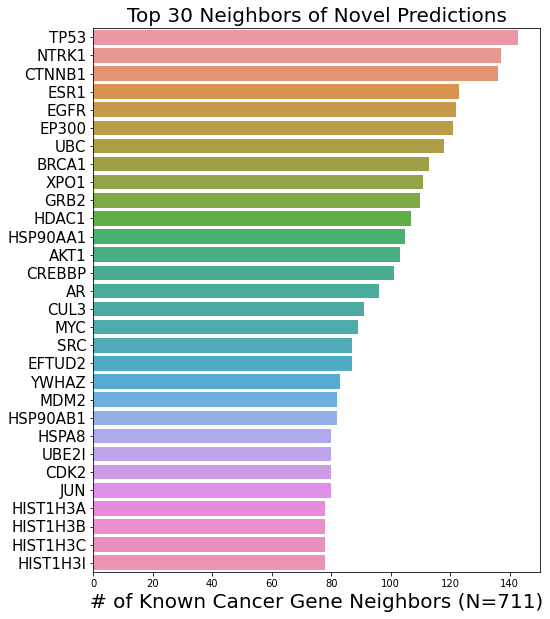

In [9]:
n_to_plot = 30

# get known cancer genes and candidates'
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

# only consider those that are in the network
known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

# get interaction partners of known cancer genes
cancer_gene_neighbors = {}
for cancer_gene in known_cancer_genes_innet:
    partners = get_all_neighbors(cancer_gene, adj, node_names)
    for partner_id, partner_name in partners:
        if partner_name in cancer_gene_neighbors:
            cancer_gene_neighbors[partner_name] += 1
        else:
            cancer_gene_neighbors[partner_name] = 1

# plot
cancer_gene_neighbors_sorted = sorted(cancer_gene_neighbors.items(), key=operator.itemgetter(1), reverse=True)
to_plot = cancer_gene_neighbors_sorted[:n_to_plot]
fig = plt.figure(figsize=(8, 10))
sns.barplot(y=[i[0] for i in to_plot], x=[i[1] for i in to_plot], orient='h')
plt.title('Top {} Neighbors of Novel Predictions'.format(n_to_plot), size=20)
plt.xlabel('# of Known Cancer Gene Neighbors (N={})'.format(len(known_cancer_genes)), size=20)
plt.gca().tick_params(axis='y', labelsize=15)
fig.savefig(os.path.join(all_models_dir, 'ncgknown_neighbors_consensus.svg'))

In [10]:
novel_predictions = [i[0] for i in consensus_sorted]
A = pd.DataFrame(adj, index=node_names[:, 1], columns=node_names[:, 1])
novel_with_known_interactions = A.loc[A.index.isin(known_cancer_genes), A.columns.isin(novel_predictions)].sum(axis=0)
(novel_with_known_interactions > 1).sum(), novel_with_known_interactions.shape

(155, (158,))

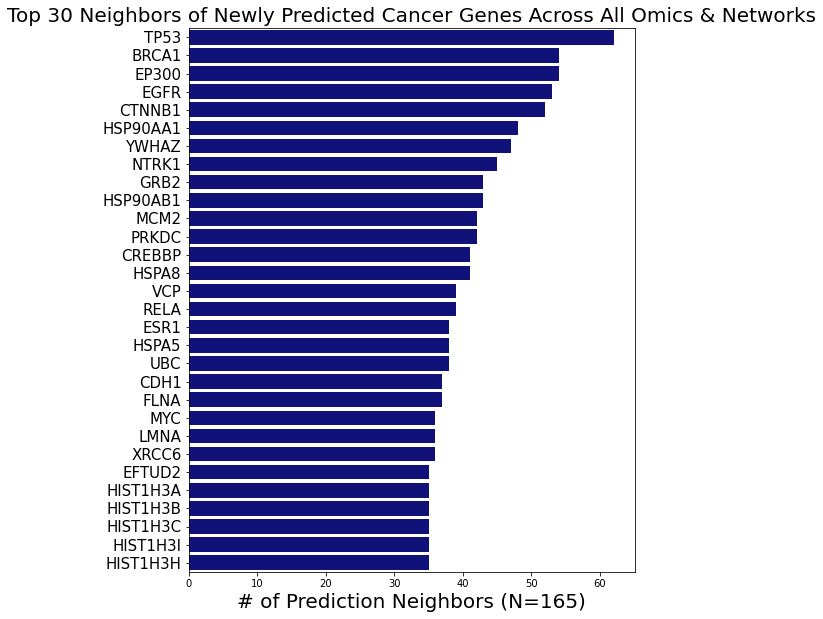

In [11]:
n_to_plot = 30

neighbors_sorted = sorted(consensus_neighbors.items(), key=operator.itemgetter(1), reverse=True)
to_plot = neighbors_sorted[:n_to_plot]
fig = plt.figure(figsize=(8, 10))
sns.barplot(y=[i[0] for i in to_plot], x=[i[1] for i in to_plot], orient='h', color='darkblue')
plt.title('Top {} Neighbors of Newly Predicted Cancer Genes Across All Omics & Networks'.format(n_to_plot), size=20)
plt.xlabel('# of Prediction Neighbors (N={})'.format(len(consensus_sorted)), size=20)
plt.gca().tick_params(axis='y', labelsize=15)
fig.savefig(os.path.join(all_models_dir, 'consensus_neighbors_all_networks.svg'))

In [12]:
predictions[predictions.Name == 'APP'].label.any()

False

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


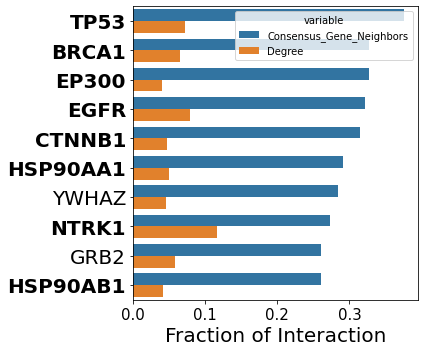

In [13]:
x = pd.DataFrame(neighbors_sorted, columns=['Name', 'Consensus_Gene_Neighbors']).set_index('Name')
A = pd.DataFrame(adj, index=node_names[:, 1], columns=node_names[:, 1])
consensus_with_neighbors = x.join(A.sum(axis=0).rename('Degree'))
consensus_with_neighbors.Degree = consensus_with_neighbors.Degree / A.shape[0] #probability to have this gene as neighbor
consensus_with_neighbors.Consensus_Gene_Neighbors /= len(consensus_sorted)
consensus_with_neighbors['Name'] = consensus_with_neighbors.index
long = pd.melt(consensus_with_neighbors.head(10), id_vars=['Name'], value_vars=['Consensus_Gene_Neighbors', 'Degree'])
fig = plt.figure(figsize=(6, 5))
sns.barplot(y=long.Name, x=long.value, hue=long.variable, orient='h')
#consensus_with_neighbors.plot(kind='bar', stacked=True)
plt.gca().tick_params(axis='y', labelsize=15)
plt.gca().tick_params(axis='x', labelsize=15)
plt.ylabel('', visible=False)
plt.xlabel('Fraction of Interaction', fontsize=20)
gene_count = 0
for lab in plt.gca().get_yticklabels():
    gene_name = lab.get_text()
    if predictions[predictions.Name == gene_name].label.any():
        plt.gca().get_yticklabels()[gene_count].set_weight('bold')
    plt.gca().get_yticklabels()[gene_count].set_fontsize(20)
    gene_count += 1
fig.tight_layout()
fig.savefig(os.path.join(all_models_dir, 'consensus_neighbors_all_networks_withrandom.svg'))

In [14]:
A = pd.DataFrame(adj, index=node_names[:, 1], columns=node_names[:, 1])
interactions_with_cancer_genes = A[A.index.isin(known_cancer_genes)].sum(axis=0).rename('Cancer_Gene_Interactions')
pred_with_interactions = predictions.join(interactions_with_cancer_genes, on='Name')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Spearman Correlation: 0.6270474815853091	P-value: 0.0


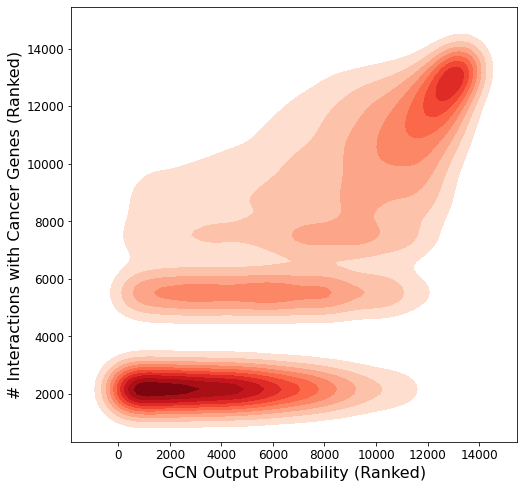

In [15]:
fig = plt.figure(figsize=(8, 8))
sns.kdeplot(pred_with_interactions.Prob_pos.rank(), pred_with_interactions.Cancer_Gene_Interactions.rank(), cmap='Reds',
            shade=True, shade_lowest=False)

#correlation = pred_with_interactions.Prob_pos.rank().corr(pred_with_interactions.Cancer_Gene_Interactions.rank())
correlation, pvalue = scipy.stats.pearsonr(pred_with_interactions.Prob_pos.rank(),
                                           pred_with_interactions.Cancer_Gene_Interactions.rank()
                                          )
print ("Spearman Correlation: {}\tP-value: {}".format(correlation, pvalue))
#plt.title('Correlation Output Probability & Cancer Gene Interactions(R = {0:.2f})'.format(correlation),
#          fontsize=25)
plt.xlabel('GCN Output Probability (Ranked)', fontsize=16)
plt.ylabel('# Interactions with Cancer Genes (Ranked)', fontsize=16)
plt.gca().tick_params(axis='both', labelsize=12)
fig.savefig(os.path.join(all_models_dir, 'correlation_cginteractions.svg'))

Text(0, 0.5, '# of Interactions\nwith Known Cancer Genes')

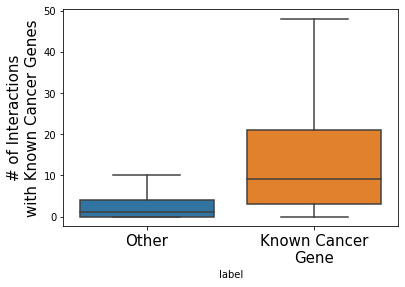

In [16]:
sns.boxplot(data=pred_with_interactions, x='label', y='Cancer_Gene_Interactions', showfliers=False)

plt.gca().tick_params(axis='x', labelsize=15)
plt.gca().set_xticklabels(['Other', 'Known Cancer\nGene'])
plt.ylabel('# of Interactions\nwith Known Cancer Genes', fontsize=15)


### Do NPCGs have a Higher Node Degree than Other Genes?

Text(0.5, 0, '')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


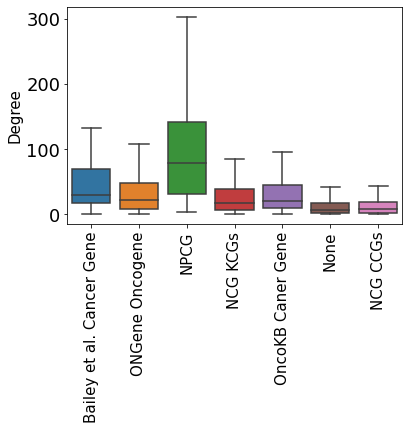

In [17]:
nodes_with_degrees = pred_with_interactions.join((A.sum(axis=1) // 2).rename('Degree'), on='Name')
npcgs = [i[0] for i in consensus_sorted]

cg_idx = nodes_with_degrees.drop(['Name', 'Degree', 'label', 'Num_Pos', 'Prob_pos', 'Std_Pred', 'Cancer_Gene_Interactions'], axis=1).any(axis='columns')
nodes_with_degrees['Cancer_Gene'] = cg_idx
nodes_with_degrees['NPCG'] = False
nodes_with_degrees.loc[nodes_with_degrees.Name.isin(npcgs), 'NPCG'] = True

nodes_with_degrees['Gene_Set'] = 'None'
nodes_with_degrees.loc[nodes_with_degrees.NCG_Candidate_Cancer_Gene, 'Gene_Set'] = 'NCG CCGs'
nodes_with_degrees.loc[nodes_with_degrees.NCG_Known_Cancer_Gene, 'Gene_Set'] = 'NCG KCGs'
nodes_with_degrees.loc[nodes_with_degrees.OncoKB_Cancer_Gene, 'Gene_Set'] = 'OncoKB Caner Gene'
nodes_with_degrees.loc[nodes_with_degrees.Bailey_et_al_Cancer_Gene, 'Gene_Set'] = 'Bailey et al. Cancer Gene'
nodes_with_degrees.loc[nodes_with_degrees.ONGene_Oncogene, 'Gene_Set'] = 'ONGene Oncogene'
nodes_with_degrees.loc[nodes_with_degrees.NPCG, 'Gene_Set'] = 'NPCG'

nodes_with_degrees['KCG_interaction_fraction'] = nodes_with_degrees.Cancer_Gene_Interactions / (nodes_with_degrees.Degree + 1)

sns.boxplot(data=nodes_with_degrees, x='Gene_Set', y='Degree', showfliers=False)
plt.ylabel('Degree', fontsize=15)
_ = plt.setp(plt.gca().get_xticklabels(), rotation=90, fontsize=15)
plt.gca().tick_params(axis='y', labelsize=18)
plt.xlabel(None)

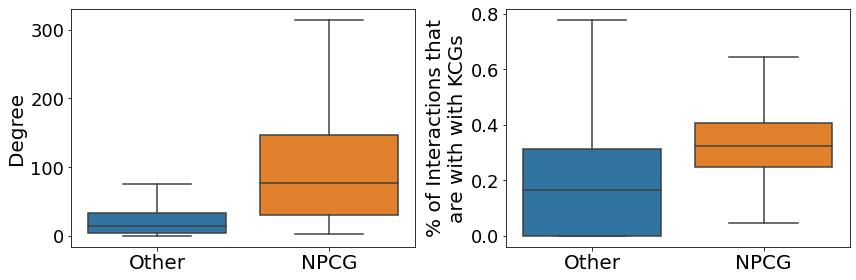

In [18]:
fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(data=nodes_with_degrees[nodes_with_degrees.Cancer_Gene], x='NPCG', y='Degree', showfliers=False)
plt.gca().set_xticklabels(['Other', 'NPCG'], fontsize=20)
plt.xlabel(None)
plt.gca().tick_params(axis='y', labelsize=18)
plt.ylabel('Degree', fontsize=20)

plt.subplot(1, 2, 2)
sns.boxplot(data=nodes_with_degrees, x='NPCG', y='KCG_interaction_fraction', showfliers=False)
plt.ylabel('% of Interactions that\nare with with KCGs', fontsize=20)
plt.gca().set_xticklabels(['Other', 'NPCG'], fontsize=20)
plt.gca().tick_params(axis='y', labelsize=18)
plt.xlabel(None)
plt.tight_layout()
fig.savefig(os.path.join(reference_model_dir, 'npcgs_degree_kcginteractions.svg'))

In [19]:
(nodes_with_degrees[nodes_with_degrees.NPCG].Cancer_Gene_Interactions >= 5).sum(), nodes_with_degrees.NPCG.sum()

(146, 158)

### Significance

In [20]:
statistic, pval = scipy.stats.ttest_ind(nodes_with_degrees[nodes_with_degrees.NPCG].KCG_interaction_fraction,
                                        nodes_with_degrees[~nodes_with_degrees.NPCG].KCG_interaction_fraction)
print ("Two-sided T-test P-value: {}".format(pval))

Two-sided T-test P-value: 1.6482310030021656e-15


### Are NPCGs Interacting with KCGs Significantly more often?

In [21]:
kcg_interaction_threshold = 0.25

high_kcg_int = nodes_with_degrees[nodes_with_degrees.KCG_interaction_fraction > kcg_interaction_threshold]
high_kcg_novel = high_kcg_int.NPCG.sum()
high_kcg_nonnovel = high_kcg_int[~high_kcg_int.NPCG].shape[0]
low_kcg_novel = nodes_with_degrees[nodes_with_degrees.KCG_interaction_fraction <= kcg_interaction_threshold].NPCG.sum()
low_kcg_nonnovel = (nodes_with_degrees[nodes_with_degrees.KCG_interaction_fraction <= kcg_interaction_threshold].shape[0] - low_kcg_novel)

cont_table = [[high_kcg_novel, high_kcg_nonnovel], [low_kcg_novel, low_kcg_nonnovel]]

# do fishers exact test
odds_ratio, pvalue = scipy.stats.fisher_exact(cont_table)
print ("P-value: {}\tOdds-Ratio: {}".format(pvalue, odds_ratio))

P-value: 4.56872773133489e-25	Odds-Ratio: 5.615971311585088


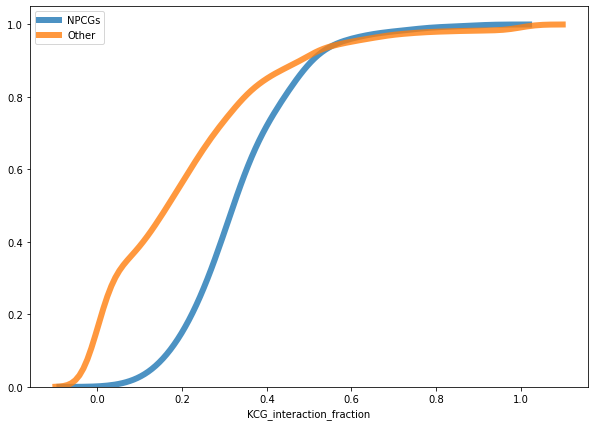

In [22]:
fig = plt.figure(figsize=(10, 7))
kwargs = dict(cumulative=True, linewidth=6, alpha=0.8)
nodes_with_degrees.loc[nodes_with_degrees.KCG_interaction_fraction > 1, 'KCG_interaction_fraction'] = 1
sns.distplot(nodes_with_degrees[nodes_with_degrees.NPCG].KCG_interaction_fraction,
             label='NPCGs', kde_kws=kwargs, hist=False)#, hist_kws=kwargs, )
sns.distplot(nodes_with_degrees[~nodes_with_degrees.NPCG].KCG_interaction_fraction,
             label='Other', kde_kws=kwargs, hist=False) #hist_kws=kwargs, 
fig.savefig(os.path.join(all_models_dir, 'cum_dist_kcginteractions.svg'))

## 3. Are NPCGs Essential in Tumor Cell Lines?
The next step is to investigate if the candidate genes from our algorithm are essential in tumor cell lines from the Achilles data.

74.88970708558337 2.0


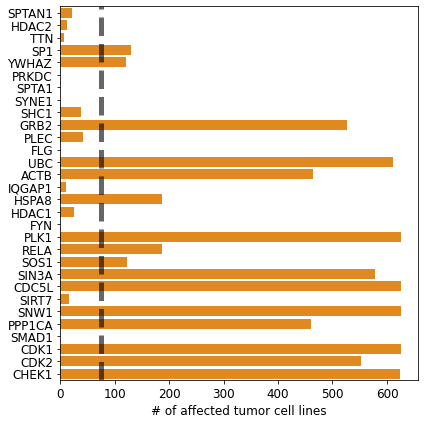

In [24]:
# load gene effect table and pre-process
essential_genes = pd.read_csv(achilles_data_path).T
essential_genes.columns = essential_genes.loc['Unnamed: 0']
essential_genes.drop('Unnamed: 0', inplace=True)
essential_genes['Name'] = [i.split('(')[0].strip() for i in essential_genes.index]
essential_genes.set_index('Name', inplace=True)

# compute number of affected cell lines for our newly predicted cancer genes
def get_number_of_affected_cellines(gene_name, achilles_data):
    # we only consider negative effects of knockouts because positives are often false
    affected_celllines = (achilles_data[achilles_data.index == gene_name] < -0.5).sum().sum()
    return affected_celllines

target_scores = []
for potential_target, _ in consensus_sorted:
    num_affected_celllines = get_number_of_affected_cellines(potential_target,  essential_genes)
    target_scores.append((potential_target, num_affected_celllines))

# random expectation
average = (essential_genes < -0.5).sum(axis=1).mean()
median = (essential_genes < -0.5).sum(axis=1).median()
print (average, median)

# plot
to_plot = target_scores[:30]
fig = plt.figure(figsize=(6, 6))
plt.gca().axvline(average, color='black', lw=5, alpha=.6, ls='--')
#plt.gca().axvline(median, color='black', lw=5, alpha=.6, ls=':')
sns.barplot(y=[i[0] for i in to_plot], x=[i[1] for i in to_plot], orient='h', color='darkorange')
plt.xlabel('# of affected tumor cell lines', fontsize=12)
plt.gca().tick_params(axis='both', labelsize=12)
fig.tight_layout()
fig.savefig(os.path.join(all_models_dir, 'consensus_genes_achilles_affected_celllines.svg'))

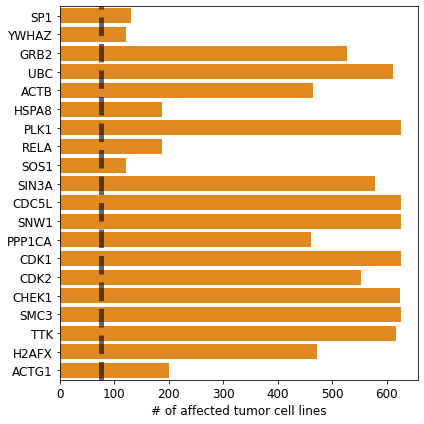

In [25]:
# plot
to_plot = [i for i in target_scores if i[1] > average][:20]
fig = plt.figure(figsize=(6, 6))
plt.gca().axvline(average, color='black', lw=5, alpha=.6, ls='--')
#plt.gca().axvline(median, color='black', lw=5, alpha=.6, ls=':')
sns.barplot(y=[i[0] for i in to_plot], x=[i[1] for i in to_plot], orient='h', color='darkorange')
plt.xlabel('# of affected tumor cell lines', fontsize=12)
plt.gca().tick_params(axis='both', labelsize=12)
fig.tight_layout()
fig.savefig(os.path.join(all_models_dir, 'npcgs_essentiality_highconf.svg'))

## Is this significant? Fishers exact test

In [26]:
# Gene essentiality = more cell lines affected than average
essentiality_scores = (essential_genes < -0.5).sum(axis=1) > average
essentiality_scores.sum(), essentiality_scores.shape

# formulate contingency table
npcgs = [i[0] for i in consensus_sorted]
essential_novel = essentiality_scores[essentiality_scores.index.isin(npcgs)].sum()
essential_nonnovel = essentiality_scores[~essentiality_scores.index.isin(npcgs)].sum()
nonessential_novel = np.logical_not(essentiality_scores[essentiality_scores.index.isin(npcgs)]).sum()
nonessential_nonnovel = np.logical_not(essentiality_scores[~essentiality_scores.index.isin(npcgs)]).sum()
cont_table = [[essential_novel, essential_nonnovel], [nonessential_novel, nonessential_nonnovel]]
print (cont_table)

# do fishers exact test
odds_ratio, pvalue = scipy.stats.fisher_exact(cont_table)
print ("P-value: {}\tOdds-Ratio: {}".format(pvalue, odds_ratio))

[[62, 2994], [101, 15176]]
P-value: 4.851258666557485e-11	Odds-Ratio: 3.1115432184501017


In [27]:
essentiality_numbers = (essential_genes < -0.5).sum(axis=1)
pred_with_cellline_effect = pred_with_interactions.join(essentiality_numbers.rename('Essential_Cellines'),
                                                        on='Name', how='inner'
                                                       )
npcgs_with_celline_effect = pred_with_cellline_effect[pred_with_cellline_effect.Name.isin(npcgs)]

In [28]:
npcgs_with_celline_effect[npcgs_with_celline_effect.Essential_Cellines > average].sort_values(by='Prob_pos', ascending=False).head(20)

,Name,label,Num_Pos,Prob_pos,Std_Pred,NCG_Known_Cancer_Gene,NCG_Candidate_Cancer_Gene,OncoKB_Cancer_Gene,Bailey_et_al_Cancer_Gene,ONGene_Oncogene,Cancer_Gene_Interactions,Essential_Cellines
ID,,,,,,,,,,,,
ENSG00000150991,UBC,False,10,1.000,0.000,False,False,False,False,False,118.000,612
ENSG00000075624,ACTB,False,10,1.000,0.000,False,True,False,False,False,54.000,465
ENSG00000185591,SP1,False,10,1.000,0.000,False,False,False,False,False,67.000,130
ENSG00000096401,CDC5L,False,10,1.000,0.000,False,False,False,False,True,57.000,625
ENSG00000109971,HSPA8,False,10,1.000,0.000,False,False,False,False,False,80.000,187
NaN,HIST1H3I,False,10,1.000,0.000,False,False,True,False,False,78.000,109
NaN,HIST2H2BE,False,10,1.000,0.000,False,False,False,False,False,29.000,260
ENSG00000100603,SNW1,False,10,1.000,0.000,False,False,False,False,False,71.000,625
ENSG00000172531,PPP1CA,False,10,1.000,0.000,False,False,False,False,False,48.000,460


In [31]:
(npcgs_with_celline_effect.Essential_Cellines >= 5).sum()

114

In [32]:
# get predictions for all networks
checked_models = 0
all_predictions = []
all_ppis = []
for network in os.listdir(all_models_dir):
    network_path = os.path.join(all_models_dir, network)
    predictions_network = None
    if all_omics:
        if os.path.isdir(network_path) and not network.startswith('.'):
            for omics in os.listdir(network_path):
                model_path = os.path.join(network_path, omics)
                if os.path.isdir(model_path) and not omics.startswith('.'):
                    predictions_network = postprocessing.load_predictions(model_path)
    else:
        print (network_path)
        if os.path.isdir(network_path) and os.path.isdir(os.path.join(network_path, 'multiomics')):
            model_path = os.path.join(network_path, 'multiomics')
            predictions_network = postprocessing.load_predictions(model_path)
    
    if not predictions_network is None:
        all_predictions.append(predictions_network)
        all_ppis.append(network)

# join together and add information on gene essentiality
def process_pred(pred, network_name):
    p_proc = pred.set_index('Name')
    p_proc = p_proc.drop(['label', 'Num_Pos', 'Std_Pred'], axis=1)
    p_proc.columns = ['Mean_{}'.format(network_name)]
    return p_proc
pred_processed = [process_pred(all_predictions[i], all_ppis[i]) for i in range(len(all_predictions))]
predictions_all_networks = pd.concat(pred_processed, axis=1, join='inner')
predictions_all_networks['Avg_Pred'] = predictions_all_networks.mean(axis=1)
pred_with_cellline_effect = predictions_all_networks.join(essentiality_numbers.rename('Essential_Cellines'), how='inner')
pred_all_npcgs = pred_with_cellline_effect[pred_with_cellline_effect.index.isin(npcgs)].sort_values(by='Avg_Pred', ascending=False)

# plot the results sorted by the highest ranking genes across all networks
# but only consider essential genes
to_plot = pred_all_npcgs[pred_all_npcgs.Essential_Cellines > average].Essential_Cellines.head(20)
fig = plt.figure(figsize=(6, 6))
plt.gca().axvline(average, color='black', lw=5, alpha=.6, ls='--')
#plt.gca().axvline(median, color='black', lw=5, alpha=.6, ls=':')
sns.barplot(y=to_plot.index, x=to_plot.values, orient='h', color='darkorange')
plt.xlabel('# of affected tumor cell lines', fontsize=12)
plt.gca().tick_params(axis='both', labelsize=12)
plt.ylabel(None)
fig.tight_layout()
#fig.savefig(os.path.join(all_models_dir, 'npcgs_essentiality_sortedallnetworks_overaverage.svg'))

../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB_notsogood
../data/GCN/training/Rev1_CNA_separated_all_networks/.ipynb_checkpoints
../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB
../data/GCN/training/Rev1_CNA_separated_all_networks/PCNet
../data/GCN/training/Rev1_CNA_separated_all_networks/STRINGdb
../data/GCN/training/Rev1_CNA_separated_all_networks/IRefIndex
../data/GCN/training/Rev1_CNA_separated_all_networks/Multinet
../data/GCN/training/Rev1_CNA_separated_all_networks/IRefIndex_2015
../data/GCN/training/Rev1_CNA_separated_all_networks/consensus_candidates_cnasep.tsv
../data/GCN/training/Rev1_CNA_separated_all_networks/consensus_genes_multiomics.svg
../data/GCN/training/Rev1_CNA_separated_all_networks/ncgknown_neighbors_consensus.svg
../data/GCN/training/Rev1_CNA_separated_all_networks/consensus_neighbors_all_networks.svg
../data/GCN/training/Rev1_CNA_separated_all_networks/consensus_neighbors_all_networks_withrandom.svg
../data/GCN/training/Rev1_CNA_separated_al

ValueError: No objects to concatenate

In [33]:
affected_celllines[affected_celllines.sum(axis=1) > affected_celllines.sum(axis=1).mean()]
affected_celllines.sum(axis=1).median()

NameError: name 'affected_celllines' is not defined

Text(0, 0.5, 'Fraction')

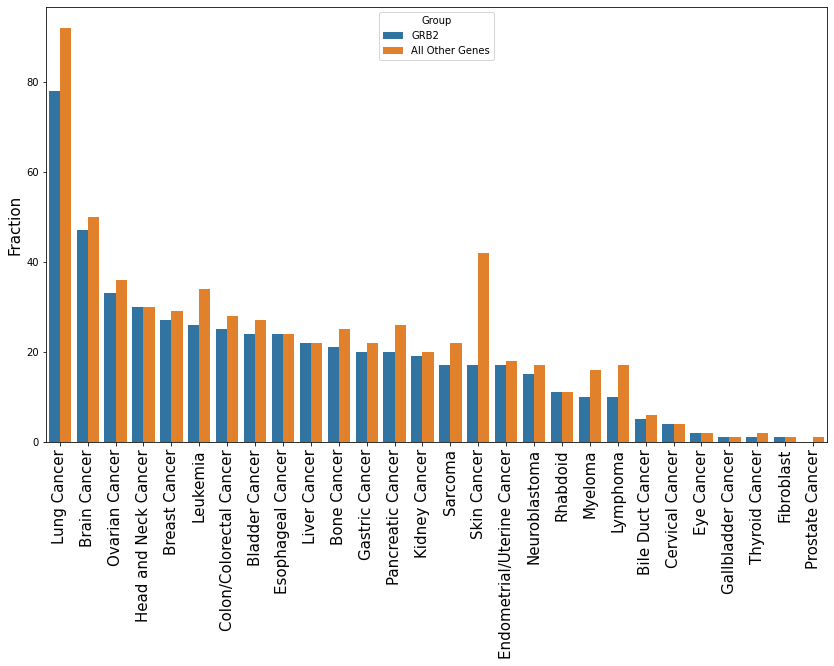

In [34]:
gene_name = 'GRB2'

cellline_info = pd.read_csv('../data/pancancer/Achilles/sample_info.csv').set_index('DepMap_ID')
cellline_info = cellline_info[cellline_info.index.isin(essential_genes.columns)]

affected_celllines = (essential_genes[essential_genes.index == gene_name] < -0.5).T
meta_for_gene = cellline_info[cellline_info.index.isin(affected_celllines.index[affected_celllines[gene_name] == True])]
celllines_gene = pd.DataFrame(meta_for_gene.disease.value_counts())
celllines_gene['Group'] = gene_name
cellline_fractions = pd.DataFrame(cellline_info.disease.value_counts())
cellline_fractions['Group'] = 'All Other Genes'
to_plot = pd.concat((celllines_gene, cellline_fractions))
to_plot['disease_label'] = to_plot.index
fig = plt.figure(figsize=(14, 8))
sns.barplot(data=to_plot, x='disease_label', y='disease', hue='Group')
_ = plt.xticks(rotation=90, fontsize=15)
plt.xlabel(None)
plt.ylabel('Fraction', fontsize=15)

In [35]:
pred_with_cellline_effect = pred_with_cellline_effect.join(pd.DataFrame(adj, index=node_names[:, 1]).sum(axis=1).rename('Degree'), on='Name')

In [36]:
to_plot[to_plot.index == 'Skin Cancer']

,disease,Group,disease_label
Skin Cancer,17,GRB2,Skin Cancer
Skin Cancer,42,All Other Genes,Skin Cancer


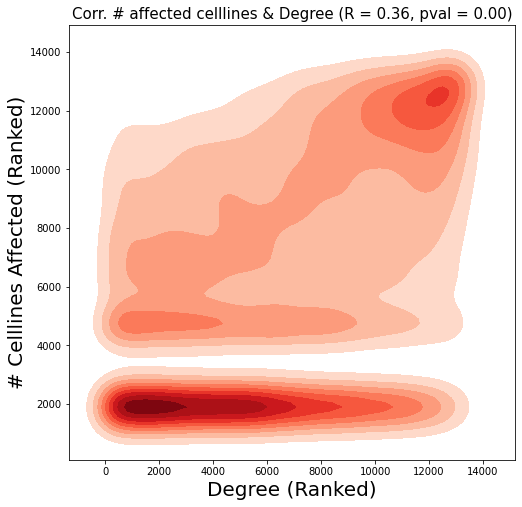

In [37]:
fig = plt.figure(figsize=(8, 8))
sns.kdeplot(pred_with_cellline_effect.Degree.rank(), pred_with_cellline_effect.Essential_Cellines.rank(), cmap='Reds',
            shade=True, shade_lowest=False)
rho, pval = scipy.stats.spearmanr(pred_with_cellline_effect.Degree, pred_with_cellline_effect.Essential_Cellines)
plt.title('Corr. # affected celllines & Degree (R = {0:.2f}, pval = {1:.2f})'.format(rho, pval), fontsize=15)
plt.xlabel('Degree (Ranked)', fontsize=20)
plt.ylabel('# Celllines Affected (Ranked)', fontsize=20)
fig.savefig(os.path.join(reference_model_dir, 'corr_celllines_degree.svg'))

## Are NPCGs Housekeeping Genes?

In [38]:
# load gtex tissues
dir_name = '../data/pancancer/TCGA/expression/tcga_expr_datadescriptor_normalized_batchcorr/'
gtex_path = os.path.join(dir_name, '{}-rsem-fpkm-gtex.txt.gz')

all_gtex_tissues = []
tissue_pairs = [('bladder', 'blca'), ('breast', 'brca'), ('cervix', 'cesc'),
                ('uterus', 'ucec'), ('colon', 'read'),
                ('colon', 'coad'), ('liver', 'lihc'), ('salivary', 'hnsc'),
                ('esophagus_mus', 'esca'), ('prostate', 'prad'), ('stomach', 'stad'),
                ('thyroid', 'thca'), ('lung', 'luad'), ('lung', 'lusc'),
                ('kidney', 'kirc'), ('kidney', 'kirp')]
for gtex_tissue, tcga_project in tissue_pairs:
    ge_tissue = pd.read_csv(gtex_path.format(gtex_tissue), compression='gzip', sep='\t')
    ge_tissue = ge_tissue.set_index('Hugo_Symbol').drop('Entrez_Gene_Id', axis=1)
    all_gtex_tissues.append(ge_tissue)

# concatenate to obtain one single gene x sample matrix
all_gtex_samples = pd.concat(all_gtex_tissues, axis=1)

In [39]:
# load some known housekeeping genes for quality control
known_hk_genes = pd.read_csv('../data/HK_genes.txt', sep='\t', header=None, names=['Symbol', 'ID'])
known_hk_genes['Symbol'] = known_hk_genes.Symbol.str.strip()
known_hk_genes.head()

,Symbol,ID
0,AAAS,NM_015665
1,AAGAB,NM_024666
2,AAMP,NM_001087
3,AAR2,NM_015511
4,AARS,NM_001605


20089 genes considered


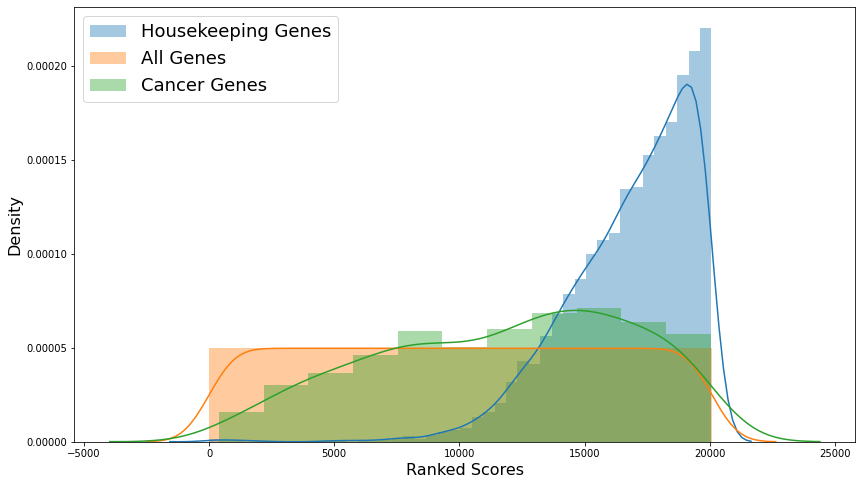

In [40]:
# compute median and std for gene expression
ge_median = all_gtex_samples.median(axis=1)
ge_var = all_gtex_samples.std(axis=1)

# compute a score that tells us how "housekeeping" a gene is
score = ge_median * (1. / ge_var)
#score = all_gtex_samples[ge_median > 150].std(axis=1)
print ("{} genes considered".format(score.shape[0]))
gene_scores = pd.DataFrame(score.sort_values(), columns=['Variance'])
gene_scores['Rank'] = np.arange(gene_scores.shape[0]) + 1

# verify that the housekeeping genes have a higher rank
fig = plt.figure(figsize=(14, 8))
sns.distplot(gene_scores[gene_scores.index.isin(known_hk_genes.Symbol)].Rank, label='Housekeeping Genes')
sns.distplot(gene_scores.Rank, label='All Genes')
sns.distplot(gene_scores[gene_scores.index.isin(known_cancer_genes)].Rank, label='Cancer Genes')
plt.ylabel('Density', fontsize=16)
plt.xlabel('Ranked Scores', fontsize=16)
plt.legend(fontsize=18)
fig.savefig(os.path.join(all_models_dir, 'known_housekeeping_score_distributions.svg'))

In [41]:
# DF for essentiality
gene_effects = (essential_genes < -0.5).sum(axis=1).rename('Celllines_Affected')
consensus_genes = [i[0] for i in consensus_sorted]
gene_effects_copy = pd.DataFrame(gene_effects.copy())
gene_effects_copy['Gene_Set'] = 'Other'
gene_effects_copy.loc[gene_effects_copy.index.isin(consensus_genes), 'Gene_Set'] = 'Novel\nPredictions'
gene_effects_copy.loc[gene_effects_copy.index.isin(known_cancer_genes), 'Gene_Set'] = 'Known Cancer\nGenes\n(NCG)'
gene_effects_copy.loc[gene_effects_copy.index.isin(candidate_cancer_genes), 'Gene_Set'] = 'Candidate\nGenes\n(NCG)'

# add housekeeping information
gene_effects_housekeeping = gene_effects_copy.join(score.rename('HousekeepingScore')).dropna()
gene_effects_housekeeping['IsHousekeeping'] = False
gene_effects_housekeeping.loc[gene_effects_housekeeping.index.isin(known_hk_genes.Symbol), 'IsHousekeeping'] = True

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


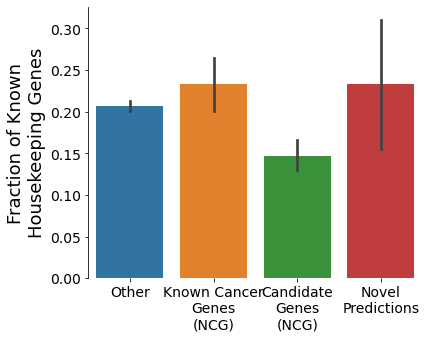

In [42]:
fig = plt.figure(figsize=(6, 5))
sns.barplot(data=gene_effects_housekeeping, x='Gene_Set', y='IsHousekeeping')
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.ylabel('Fraction of Known\nHousekeeping Genes', fontsize=18)
plt.gca().tick_params(axis='both', labelsize=14)
fig.savefig(os.path.join(all_models_dir, 'achilles_known_housekeeping_genesets.svg'))

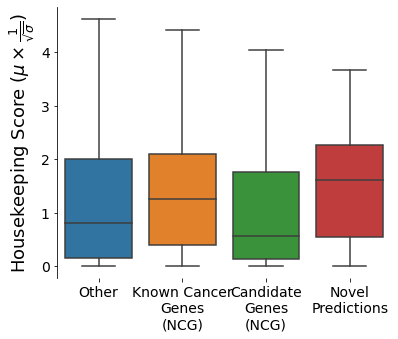

In [44]:
fig = plt.figure(figsize=(6, 5))
sns.boxplot(data=gene_effects_housekeeping, x='Gene_Set', y='HousekeepingScore', showfliers=False)
#sns.swarmplot(data=gene_effects_copy, x='Gene_Set', y='Celllines_Affected')
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#plt.ylabel('# of Affected Cell Lines', fontsize=18)
plt.ylabel('Housekeeping Score ($\mu \\times \\frac{1}{\sqrt{\sigma}}$)', fontsize=18)
plt.gca().tick_params(axis='both', labelsize=14)
fig.savefig(os.path.join(all_models_dir, 'achilles_housekeepingScore_genesets.svg'))

## Are Essential Genes Enriched for Housekeeping Function?

Pearson Correlation: 0.38699513845506367	P-value: 0.0


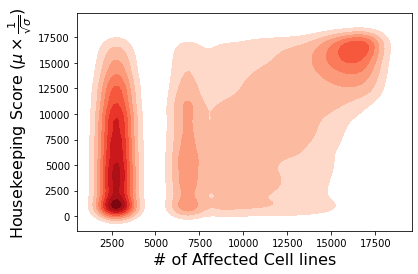

In [45]:
correlation, pvalue = scipy.stats.spearmanr(gene_effects_housekeeping.Celllines_Affected,
                                           gene_effects_housekeeping.HousekeepingScore
                                          )
sns.kdeplot(gene_effects_housekeeping.Celllines_Affected.rank(),
            gene_effects_housekeeping.HousekeepingScore.rank(),
            cmap='Reds',
            shade=True, shade_lowest=False
           )
plt.ylabel('Housekeeping Score ($\mu \\times \\frac{1}{\sqrt{\sigma}}$)', fontsize=16)
plt.xlabel('# of Affected Cell lines', fontsize=16)
print ("Pearson Correlation: {}\tP-value: {}".format(correlation, pvalue))
fig.savefig(os.path.join(reference_model_dir, 'achilles_housekeeping_correlation.svg'))

## Essentiality Across Gene Sets

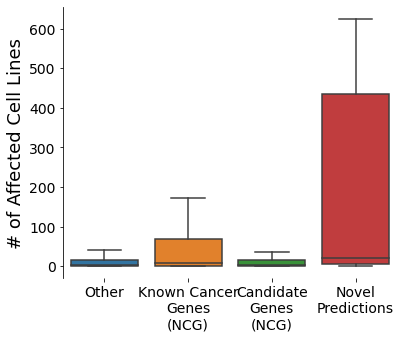

In [28]:
fig = plt.figure(figsize=(6, 5))
sns.boxplot(data=gene_effects_copy, x='Gene_Set', y='Celllines_Affected', showfliers=False)
#sns.swarmplot(data=gene_effects_copy, x='Gene_Set', y='Celllines_Affected')
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.ylabel('# of Affected Cell Lines', fontsize=18)
plt.gca().tick_params(axis='both', labelsize=14)
fig.savefig(os.path.join(all_models_dir, 'achilles_effects_genesets.svg'))

In [29]:
# significance test between NPCGs and KCGs
kcgs = gene_effects_copy[gene_effects_copy.Gene_Set == 'Known Cancer\nGenes\n(NCG)']
npcgs = gene_effects_copy[gene_effects_copy.Gene_Set == 'Novel\nPredictions']
npcgs_essential = (npcgs.Celllines_Affected > 78).sum()
npcgs_nonessential = npcgs.shape[0] - npcgs_essential
kcgs_essential = (kcgs.Celllines_Affected > 78).sum()
kcgs_nonessential = kcgs.shape[0] - kcgs_essential

cont = [[npcgs_essential, npcgs_nonessential], [kcgs_essential, kcgs_nonessential]]
odds_ratio, pvalue = scipy.stats.fisher_exact(cont)
print (pvalue)

0.015304263373330615


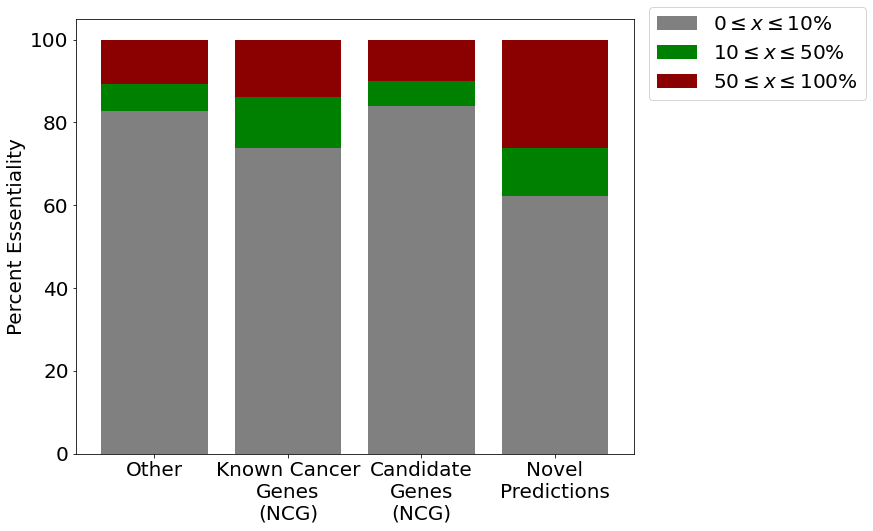

In [30]:
stacked_barplot_vals = {}
gene_sets = gene_effects_copy.Gene_Set.unique()
groups = list(range(len(gene_sets)))
fractions = [(0, 625./10.), (625./10., 625./2.), (625./2., 625)]

for gene_set in gene_sets:
    frac_vals = []
    for min_v, max_v in fractions:
        v = gene_effects_copy[gene_effects_copy.Gene_Set == gene_set].Celllines_Affected.between(min_v, max_v).sum()
        frac_vals.append(v)
    stacked_barplot_vals[gene_set] = frac_vals

df = pd.DataFrame(stacked_barplot_vals, index=['0_10', '10_50', '50_100']).T
totals = [i+j+k for i,j,k in zip(df['0_10'], df['10_50'], df['50_100'])]
bars_0_10 = [i / j * 100 for i,j in zip(df['0_10'], totals)]
bars_10_50 = [i / j * 100 for i,j in zip(df['10_50'], totals)]
bars_50_100 = [i / j * 100 for i,j in zip(df['50_100'], totals)]

fig = plt.figure(figsize=(10, 8))
plt.bar(groups, bars_0_10, color='gray', label='$0 \leq x \leq 10$%')
plt.bar(groups, bars_10_50, bottom=bars_0_10, color='green', label='$10 \leq x \leq 50$%')
plt.bar(groups, bars_50_100, bottom=[i+j for i,j in zip(bars_0_10, bars_10_50)],
        color='darkred', label='$50 \leq x \leq 100$%')

plt.legend(bbox_to_anchor=(1.01, 1.05), ncol=1, fontsize=20)
plt.ylabel('Percent Essentiality', fontsize=20)
_ = plt.xticks(groups, gene_sets, fontsize=15)
plt.gca().tick_params(axis='both', which='major', labelsize=20)
fig.savefig(os.path.join(all_models_dir, 'essentiality_genesets_grouped.svg'))

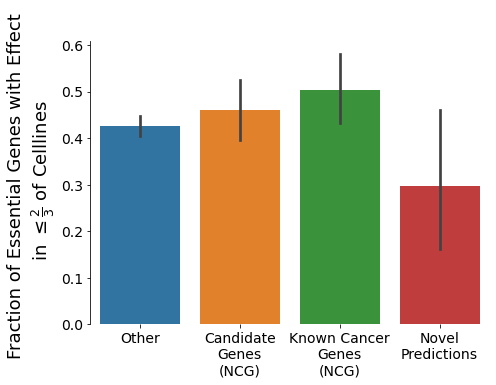

In [47]:
fig = plt.figure(figsize=(7, 5))
gene_effects_copy['onethird'] = gene_effects_copy.Celllines_Affected.between(0, 417)
#essential_thr = gene_effects_copy.Celllines_Affected.mean()
essential_thr = 78
gene_effects_essentialonly = gene_effects_copy[gene_effects_copy.Celllines_Affected > essential_thr]
sns.barplot(data=gene_effects_essentialonly, x='Gene_Set', y='onethird')
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.ylabel('Fraction of Essential Genes with Effect \n in $\leq \\frac{2}{3}$ of Celllines', fontsize=18)
#plt.ylabel('Fraction of Genes with Effect \n in $\\frac{1}{3} \leq x \leq \\frac{2}{3}$ of Celllines', fontsize=18)
plt.gca().tick_params(axis='both', labelsize=14)
fig.tight_layout()
fig.savefig(os.path.join(all_models_dir, 'achilles_effects_twothirds.svg'))

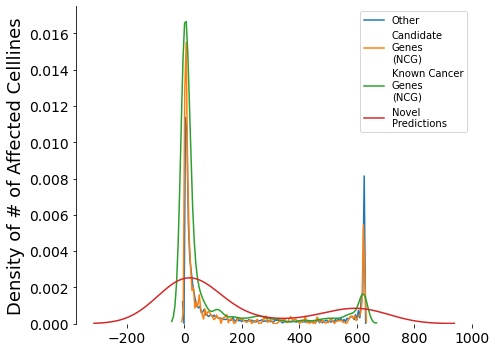

In [50]:
fig = plt.figure(figsize=(7, 5))
gene_effects_copy['onethird'] = gene_effects_copy.Celllines_Affected.between(208, 417)
#essential_thr = gene_effects_copy.Celllines_Affected.mean()
essential_thr = 78
gene_effects_essentialonly = gene_effects_copy[gene_effects_copy.Celllines_Affected > essential_thr]
#sns.barplot(data=gene_effects_essentialonly, x='Gene_Set', y='onethird')
for i in gene_effects_essentialonly.Gene_Set.unique():
    d = gene_effects_copy[gene_effects_copy.Gene_Set == i]
    sns.kdeplot(d.Celllines_Affected, label=i)
    #sns.distplot(d.Celllines_Affected, kde=False, label=i, bins=np.linspace(78, 625, 100), norm_hist=True)
plt.legend()
#sns.kdeplot(data=gene_effects_essentialonly, x='onethird', hue='Gene_Set')
plt.xlabel(None)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.ylabel('Density of # of Affected Celllines', fontsize=18)
#plt.ylabel('Fraction of Essential Genes with Effect \n in $\\frac{1}{3} \leq x \leq \\frac{2}{3}$ of Celllines', fontsize=18)
#plt.ylabel('Fraction of Genes with Effect \n in $\\frac{1}{3} \leq x \leq \\frac{2}{3}$ of Celllines', fontsize=18)
plt.gca().tick_params(axis='both', labelsize=14)
#plt.xlim([0, 700])
fig.tight_layout()
fig.savefig(os.path.join(all_models_dir, 'achilles_effects_density.svg'))

In [51]:
pred_with_cellline_effect.head()

,Name,label,Num_Pos,Prob_pos,Std_Pred,NCG_Known_Cancer_Gene,NCG_Candidate_Cancer_Gene,OncoKB_Cancer_Gene,Bailey_et_al_Cancer_Gene,ONGene_Oncogene,Cancer_Gene_Interactions,Essential_Cellines
ID,,,,,,,,,,,,
ENSG00000100393,EP300,True,10,1.000,0.000,True,False,True,True,False,121.000,266
ENSG00000133703,KRAS,True,10,1.000,0.000,True,False,True,True,True,24.000,247
ENSG00000155657,TTN,False,10,1.000,0.000,False,True,False,False,False,18.000,8
ENSG00000284792,PTEN,True,10,1.000,0.000,True,False,True,True,False,32.000,2
ENSG00000039068,CDH1,True,10,1.000,0.000,True,False,True,True,True,66.000,34


/pkg/python-3.7.7-0/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/pkg/python-3.7.7-0/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


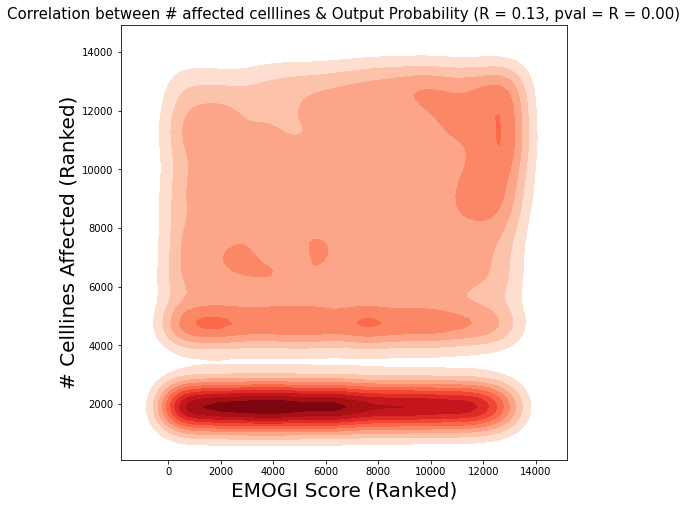

In [29]:
fig = plt.figure(figsize=(8, 8))
pred_with_effects = pred_with_cellline_effect[['Prob_pos', 'Essential_Cellines']]
pred_with_effects.columns = ['Prob_pos', 'Celllines_Affected']
pred_with_effects['Effect_Rank'] = pred_with_effects.Celllines_Affected.rank()
pred_with_effects.Effect_Rank.fillna(0, inplace=True)
sns.kdeplot(pred_with_effects.Prob_pos.rank(), pred_with_effects.Effect_Rank, cmap='Reds',
            shade=True, shade_lowest=False)
rho, pval = scipy.stats.spearmanr(pred_with_effects.Prob_pos, pred_with_effects.Celllines_Affected)
plt.title('Correlation between # affected celllines & Output Probability (R = {0:.2f}, pval = R = {1:.2f})'.format(rho, pval), fontsize=15)
plt.xlabel('EMOGI Score (Ranked)', fontsize=20)
plt.ylabel('# Celllines Affected (Ranked)', fontsize=20)
fig.savefig(os.path.join(reference_model_dir, 'corr_celllines_output.svg'))

In [10]:
consensus_cancergenes = pd.DataFrame(consensus_sorted, columns=['Name', 'Models_top{}'.format(top_n)]).set_index('Name')

# add column for presence in NCG Candidate Cancer Genes
consensus_cancergenes['NCG_Candidates'] = consensus_cancergenes.index.isin(candidate_cancer_genes)

# add column for presence in OncoKB (anywhere there, not only high confidence)
oncokb_genes = pd.read_csv('/project/gcn/diseasegcn/data/pancancer/oncoKB/cancerGeneList.txt', sep='\t')
consensus_cancergenes['OncoKB'] = consensus_cancergenes.index.isin(oncokb_genes['Hugo Symbol'])

# add column for the number of cell lines in which the gene is essential (Achilles data)
consensus_effects = pd.DataFrame(target_scores, columns=['Name', 'Affected_Celllines']).set_index('Name')
consensus_cancergenes = consensus_cancergenes.join(consensus_effects)
#consensus_cancergenes.to_csv(os.path.join(all_models_dir, 'consensus_candidates_cnasep.tsv'), sep='\t')

NameError: name 'candidate_cancer_genes' is not defined

## Check if NPCGs are Similar When CNAs Are Separate

In [68]:
old_npcgs = pd.read_csv('../data/GCN/training/final_TCGA_all_networks/consensus_candidates.tsv', sep='\t')
len(set(old_npcgs.Name).intersection(set(npcgs))), len(old_npcgs), len(consensus_sorted)

(101, 212, 165)